# AI-Powered Wardrobe Recommender: Training Pipeline

## Abstract
This notebook presents a comprehensive training pipeline for fashion item classification using deep convolutional neural networks. The system employs transfer learning with ResNet50 architecture pre-trained on ImageNet, fine-tuned for fashion domain-specific classification tasks.

## Objectives
1. Exploratory Data Analysis (EDA) of fashion dataset
2. Transfer Learning with ResNet50 for feature extraction
3. Model training and hyperparameter optimization
4. Comprehensive evaluation and performance analysis
5. Feature vector extraction for similarity-based recommendation

## Dataset Information
- **Source:** DeepFashion Category and Attribute Prediction Dataset
- **Full Dataset:** 20,000 images (45 categories)
- **Subset:** 821 images (5 categories: Blazer, Blouse, Dress, Skirt, Tee)
- **Split:** Training (521), Validation (150), Test (150)
- **Task:** Multi-class fashion item classification

## Model Architecture
- **Backbone:** ResNet50 (Pre-trained on ImageNet)
- **Strategy:** Transfer Learning with fine-tuning
- **Output:** Class predictions and feature embeddings (2048-dimensional vectors)

## 1. Setup and Imports

In [19]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

# Import custom modules
sys.path.append(str(Path.cwd().parent))
from src.model import ResNet50Classifier, freeze_backbone
from src.dataset_loader import get_dataloaders

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device - prioritize MPS (Apple Silicon GPU), then CUDA, then CPU
if torch.backends.mps.is_available():
    device = "mps"
    print("Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = "cuda"
    print("Using NVIDIA GPU (CUDA)")
else:
    device = "cpu"
    print("Using CPU")

print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using Apple Silicon GPU (MPS)
Device: mps
PyTorch version: 2.9.0


## 2. Exploratory Data Analysis
This section examines the dataset structure, class distribution, and visual characteristics of the fashion items.

In [20]:
# Dataset paths
DATA_ROOT = "../data/deepfashion_subset"
RESULTS_DIR = "../results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Check dataset structure
for split in ['train', 'val', 'test']:
    split_path = Path(DATA_ROOT) / split
    if split_path.exists():
        classes = [d.name for d in split_path.iterdir() if d.is_dir()]
        print(f"\n{split.upper()} set:")
        print(f"  Classes: {classes}")
        for cls in classes:
            num_images = len(list((split_path / cls).glob('*.jpg'))) + len(list((split_path / cls).glob('*.png')))
            print(f"  - {cls}: {num_images} images")


TRAIN set:
  Classes: ['Tee', 'Skirt', 'Dress', 'Blouse', 'Blazer']
  - Tee: 81 images
  - Skirt: 76 images
  - Dress: 93 images
  - Blouse: 140 images
  - Blazer: 131 images

VAL set:
  Classes: ['Tee', 'Skirt', 'Dress', 'Blouse', 'Blazer']
  - Tee: 30 images
  - Skirt: 30 images
  - Dress: 30 images
  - Blouse: 30 images
  - Blazer: 30 images

TEST set:
  Classes: ['Tee', 'Skirt', 'Dress', 'Blouse', 'Blazer']
  - Tee: 30 images
  - Skirt: 30 images
  - Dress: 30 images
  - Blouse: 30 images
  - Blazer: 30 images


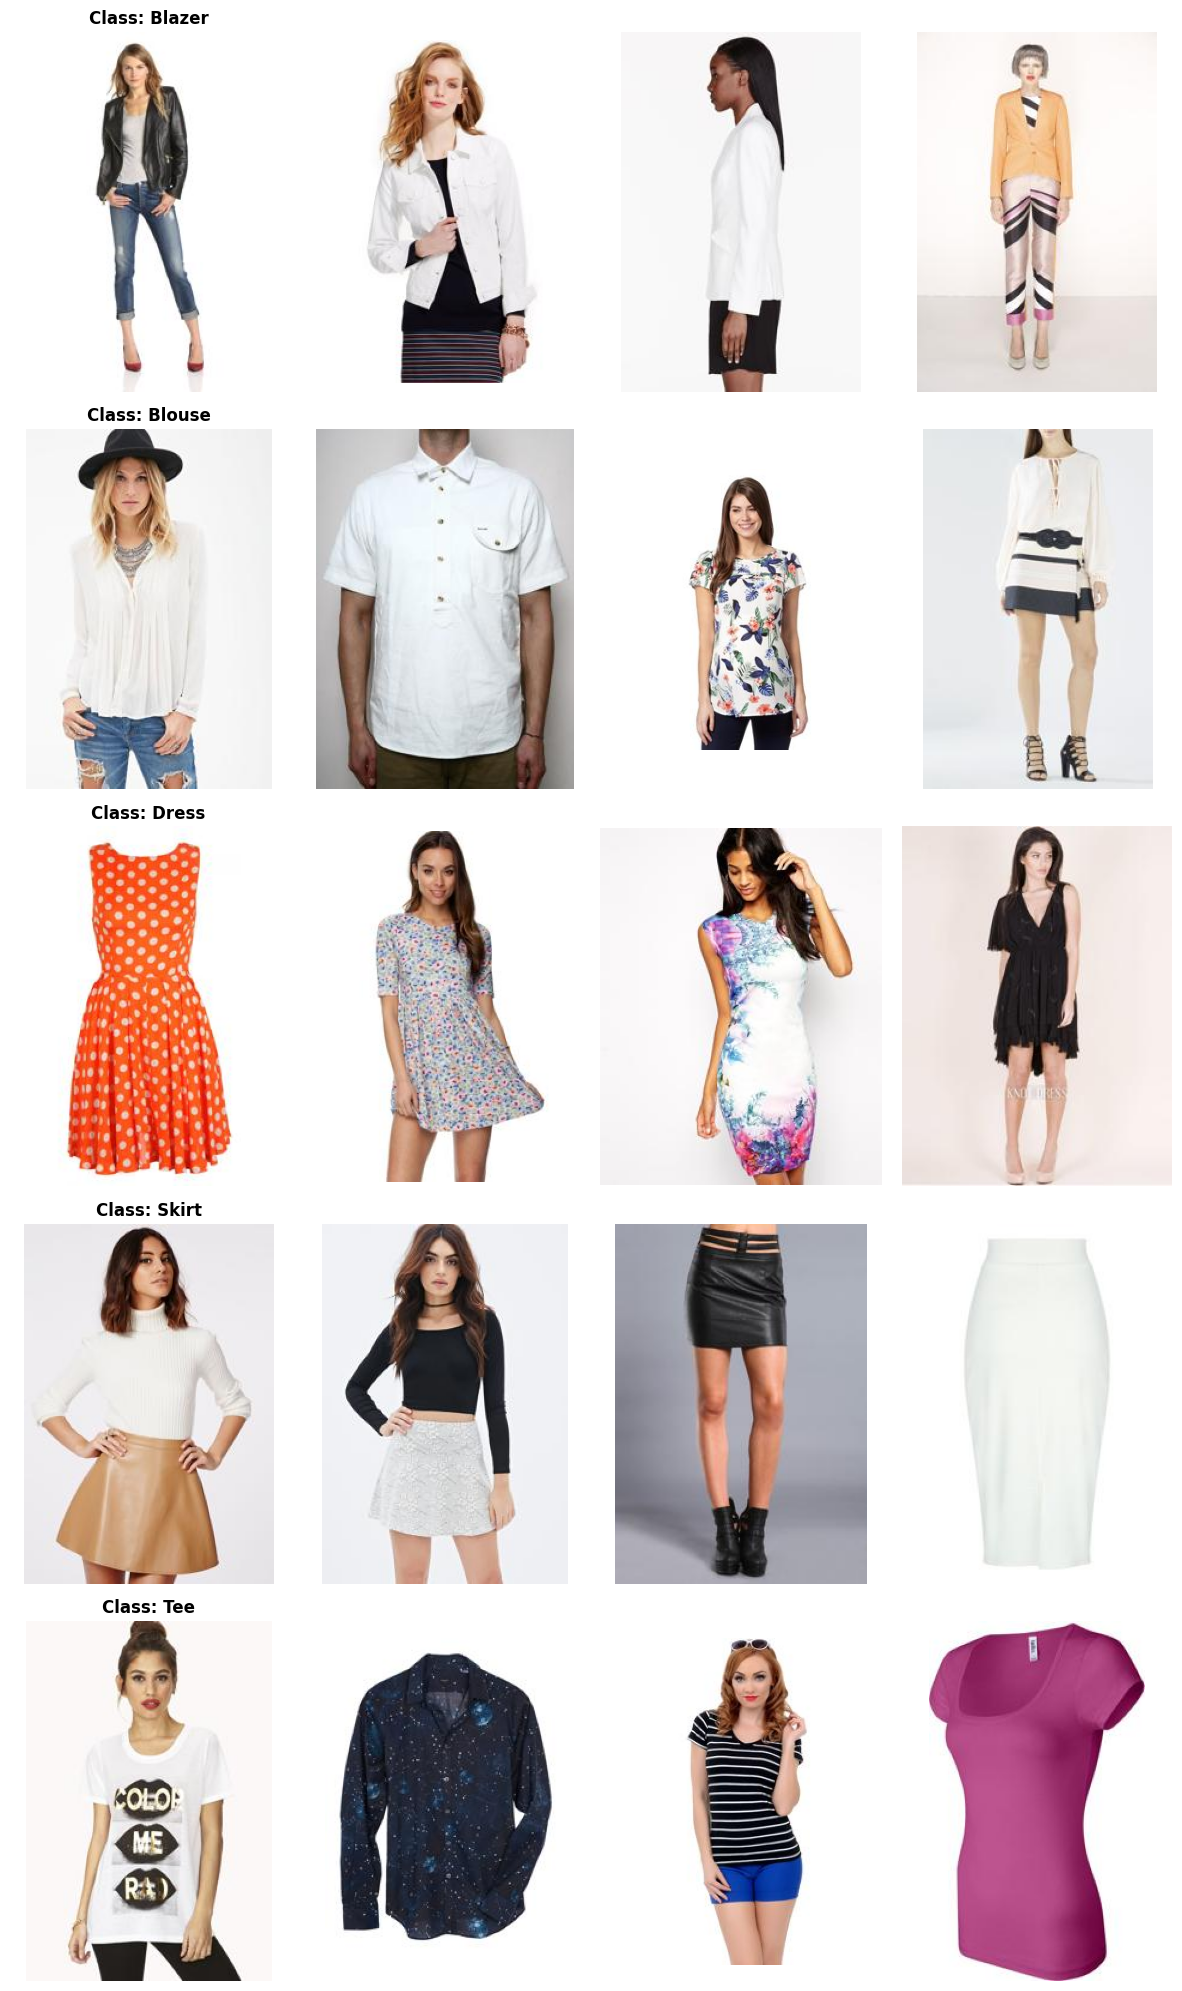

In [21]:
# Visualize sample images from each class
def show_sample_images(data_root, split='train', samples_per_class=3):
    split_path = Path(data_root) / split
    classes = sorted([d.name for d in split_path.iterdir() if d.is_dir()])
    
    fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(12, 4*len(classes)))
    if len(classes) == 1:
        axes = axes.reshape(1, -1)
    
    for i, cls in enumerate(classes):
        image_paths = list((split_path / cls).glob('*.jpg')) + list((split_path / cls).glob('*.png'))
        for j in range(min(samples_per_class, len(image_paths))):
            img = Image.open(image_paths[j]).convert('RGB')
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f"Class: {cls}", fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'sample_images.png'), dpi=150, bbox_inches='tight')
    plt.show()

show_sample_images(DATA_ROOT, split='train', samples_per_class=4)

## 3. Data Loading and Preprocessing

In [22]:
# Load data with augmentation
batch_size = 16
img_size = 224
num_workers = 2

train_loader, val_loader, test_loader, idx_to_class = get_dataloaders(
    DATA_ROOT, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    img_size=img_size
)

num_classes = len(idx_to_class)
print(f"\nDataset Statistics:")
print(f"  Number of classes: {num_classes}")
print(f"  Class names: {list(idx_to_class.values())}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Batch size: {batch_size}")
print(f"  Image size: {img_size}x{img_size}")


Dataset Statistics:
  Number of classes: 5
  Class names: ['Blazer', 'Blouse', 'Dress', 'Skirt', 'Tee']
  Training batches: 33
  Validation batches: 10
  Test batches: 10
  Batch size: 16
  Image size: 224x224


Python(7524) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7525) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7525) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


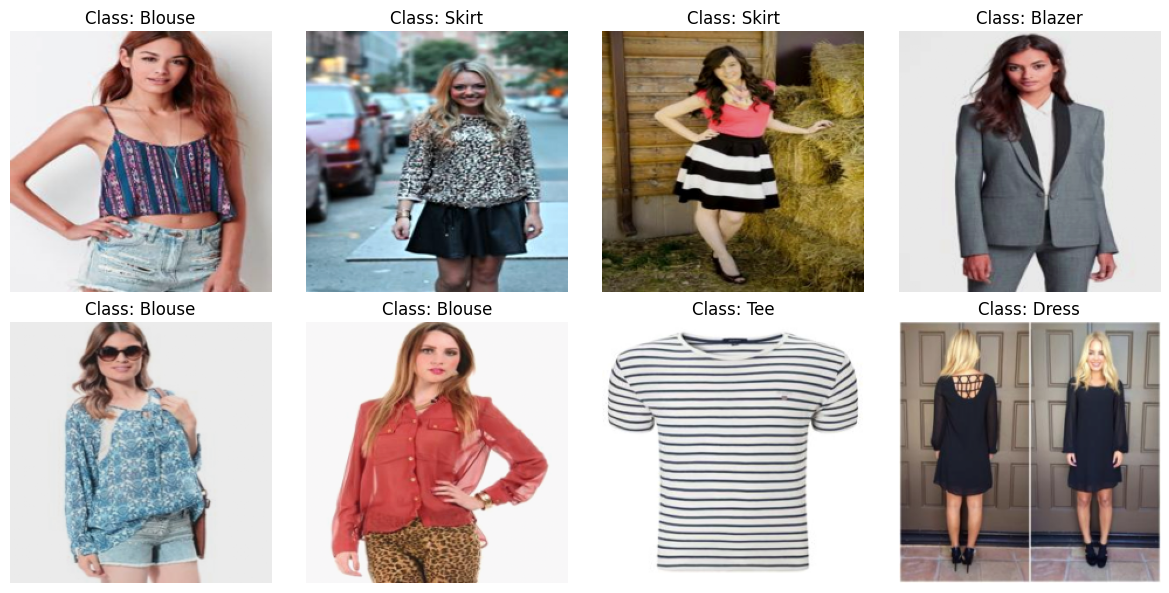

In [23]:
# Visualize a batch of augmented images
def visualize_augmented_batch(loader, num_images=8):
    images, labels = next(iter(loader))
    
    # Denormalize images for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images = images * std + mean
    images = torch.clamp(images, 0, 1)
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    
    for i in range(min(num_images, len(images))):
        img = images[i].permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {idx_to_class[labels[i].item()]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'augmented_batch.png'), dpi=150, bbox_inches='tight')
    plt.show()

visualize_augmented_batch(train_loader)

## 4. Model Architecture
Build ResNet50 with custom classifier head

In [24]:
# Initialize model
model = ResNet50Classifier(num_classes=num_classes, pretrained=True)

# Freeze backbone layers (transfer learning)
freeze_backbone(model, unfreeze_last_n=1)

# Move to device
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Architecture:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Frozen parameters: {total_params - trainable_params:,}")
print(f"\nModel Summary:")
print(model)


Model Architecture:
  Total parameters: 23,518,277
  Trainable parameters: 14,974,981
  Frozen parameters: 8,543,296

Model Summary:
ResNet50Classifier(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(25

## 5. Training Configuration

In [25]:
# Training hyperparameters
epochs = 10
learning_rate = 1e-3

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
# Note: verbose parameter removed in PyTorch 2.9.0
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

print(f"Training Configuration:")
print(f"  Epochs: {epochs}")
print(f"  Learning rate: {learning_rate}")
print(f"  Optimizer: Adam")
print(f"  Loss function: CrossEntropyLoss")
print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)")


Training Configuration:
  Epochs: 10
  Learning rate: 0.001
  Optimizer: Adam
  Loss function: CrossEntropyLoss
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)


## 6. Training Loop

In [26]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    
    progress_bar = tqdm(loader, desc="Training", leave=False)
    for x, y in progress_bar:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        logits, _ = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)
        total_correct += (preds == y).sum().item()
        total += x.size(0)
        
        progress_bar.set_postfix({'loss': loss.item(), 'acc': total_correct/total})
    
    return total_loss/total, total_correct/total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    
    progress_bar = tqdm(loader, desc="Evaluating", leave=False)
    for x, y in progress_bar:
        x, y = x.to(device), y.to(device)
        
        logits, _ = model(x)
        loss = criterion(logits, y)
        
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)
        total_correct += (preds == y).sum().item()
        total += x.size(0)
        
        progress_bar.set_postfix({'loss': loss.item(), 'acc': total_correct/total})
    
    return total_loss/total, total_correct/total

In [27]:
                        # Training loop
best_val_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []
learning_rates = []

print("\nStarting Training...\n")

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    learning_rates.append(current_lr)
    
    # Print epoch results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(RESULTS_DIR, "model_best.pth"))
        with open(os.path.join(RESULTS_DIR, "class_to_idx.json"), "w") as f:
            json.dump(idx_to_class, f)
        print(f"Model checkpoint saved (Validation Accuracy: {best_val_acc:.4f})")
    
    print()

print(f"\nTraining Complete!")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")


Starting Training...

Epoch 1/10
--------------------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Python(7593) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7594) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7594) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Python(7607) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7608) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7608) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 1.2887 | Train Acc: 0.4894
Val Loss:   1.1344 | Val Acc:   0.6200
Learning Rate: 0.001000
Model checkpoint saved (Validation Accuracy: 0.6200)

Epoch 2/10
--------------------------------------------------
Model checkpoint saved (Validation Accuracy: 0.6200)

Epoch 2/10
--------------------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Python(7621) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7622) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7622) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Python(7627) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7628) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7628) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.7367 | Train Acc: 0.7370
Val Loss:   2.4842 | Val Acc:   0.5267
Learning Rate: 0.001000

Epoch 3/10
--------------------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Python(7631) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7632) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7632) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Python(7642) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7643) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7643) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.5456 | Train Acc: 0.8311
Val Loss:   1.0515 | Val Acc:   0.6667
Learning Rate: 0.001000
Model checkpoint saved (Validation Accuracy: 0.6667)

Epoch 4/10
--------------------------------------------------
Model checkpoint saved (Validation Accuracy: 0.6667)

Epoch 4/10
--------------------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Python(7647) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7648) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7648) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Python(7656) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7657) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7657) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.2883 | Train Acc: 0.9060
Val Loss:   1.4004 | Val Acc:   0.6267
Learning Rate: 0.001000

Epoch 5/10
--------------------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Python(7663) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7664) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7664) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Python(7667) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7668) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7668) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.1774 | Train Acc: 0.9482
Val Loss:   1.0158 | Val Acc:   0.6533
Learning Rate: 0.001000

Epoch 6/10
--------------------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Python(7676) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7677) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7677) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Python(7683) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7684) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7684) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.1611 | Train Acc: 0.9616
Val Loss:   1.1015 | Val Acc:   0.6800
Learning Rate: 0.001000
Model checkpoint saved (Validation Accuracy: 0.6800)

Epoch 7/10
--------------------------------------------------
Model checkpoint saved (Validation Accuracy: 0.6800)

Epoch 7/10
--------------------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Python(7694) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7695) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7695) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Python(7698) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7699) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7699) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.1332 | Train Acc: 0.9674
Val Loss:   1.7267 | Val Acc:   0.5933
Learning Rate: 0.001000

Epoch 8/10
--------------------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Python(7702) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7703) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7703) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Python(7712) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7713) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7713) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0858 | Train Acc: 0.9750
Val Loss:   1.4348 | Val Acc:   0.6467
Learning Rate: 0.000500

Epoch 9/10
--------------------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Python(7726) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7727) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7727) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Python(7730) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7731) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7731) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.1122 | Train Acc: 0.9635
Val Loss:   1.1443 | Val Acc:   0.6733
Learning Rate: 0.000500

Epoch 10/10
--------------------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Python(7735) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7736) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7736) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Python(7740) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7741) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7741) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.0399 | Train Acc: 0.9942
Val Loss:   1.2706 | Val Acc:   0.6733
Learning Rate: 0.000500


Training Complete!
Best Validation Accuracy: 0.6800


## 7. Training Visualization

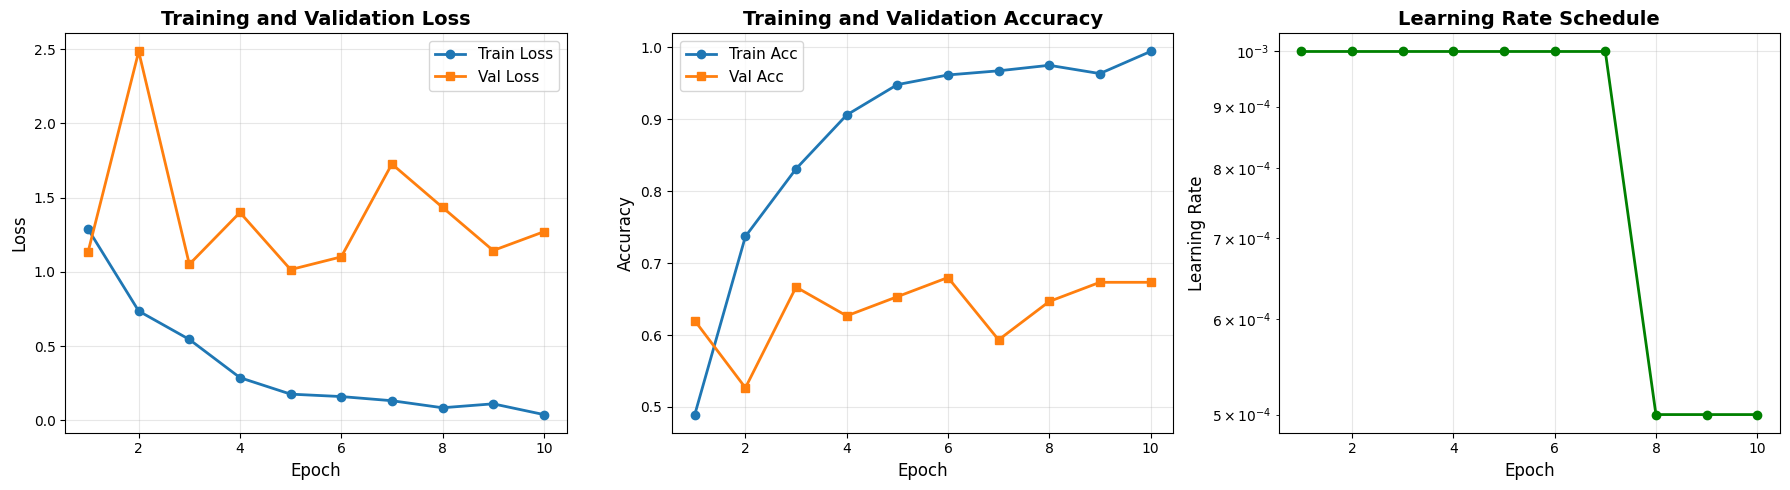

In [28]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss curve
axes[0].plot(range(1, epochs+1), train_losses, marker='o', label='Train Loss', linewidth=2)
axes[0].plot(range(1, epochs+1), val_losses, marker='s', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot(range(1, epochs+1), train_accs, marker='o', label='Train Acc', linewidth=2)
axes[1].plot(range(1, epochs+1), val_accs, marker='s', label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# Learning rate
axes[2].plot(range(1, epochs+1), learning_rates, marker='o', color='green', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Learning Rate', fontsize=12)
axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'training_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

## 8. Model Evaluation on Test Set

In [29]:
# Load best model
model.load_state_dict(torch.load(os.path.join(RESULTS_DIR, "model_best.pth"), map_location=device))
model = model.to(device)

# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f"\nTest Set Evaluation:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Python(7775) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7776) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7776) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



Test Set Evaluation:
  Test Loss: 1.3959
  Test Accuracy: 0.6533 (65.33%)


In [30]:
# Generate predictions and confusion matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits, _ = model(x)
        pred = logits.argmax(1).cpu().numpy()
        y_pred.extend(list(pred))
        y_true.extend(list(y.numpy()))

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

# Print detailed metrics
print("\nDetailed Test Metrics:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 (Macro):    {f1_macro:.4f}")
print(f"  F1 (Weighted): {f1_weighted:.4f}")

# Save metrics
metrics_dict = {
    "accuracy": float(accuracy),
    "precision": float(precision),
    "recall": float(recall),
    "f1_macro": float(f1_macro),
    "f1_weighted": float(f1_weighted)
}

with open(os.path.join(RESULTS_DIR, "test_metrics.json"), "w") as f:
    json.dump(metrics_dict, f, indent=2)

print("\nMetrics successfully saved to results/test_metrics.json")

Python(7789) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7790) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7790) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



Detailed Test Metrics:
  Accuracy:  0.6533
  Precision: 0.6603
  Recall:    0.6533
  F1 (Macro):    0.6550
  F1 (Weighted): 0.6550

Metrics successfully saved to results/test_metrics.json


In [14]:
# Classification report
print("\nClassification Report:")
print("-" * 60)
class_names = [idx_to_class[i] for i in range(num_classes)]
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

      images       1.00      1.00      1.00         9
       masks       1.00      1.00      1.00         9

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



## 9. Confusion Matrix Visualization

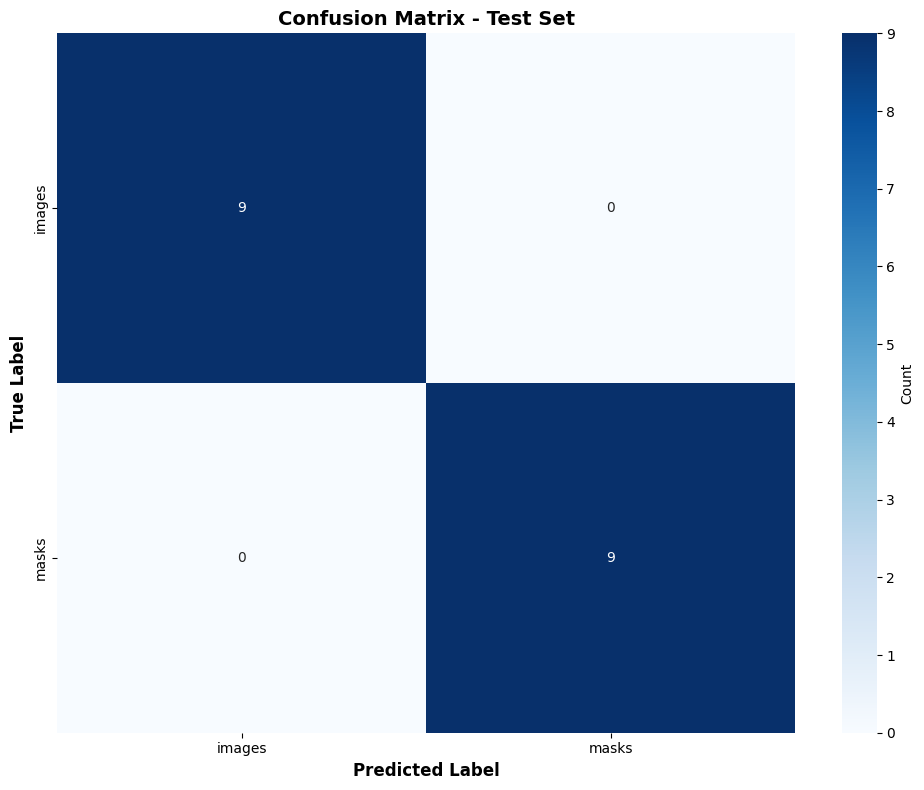

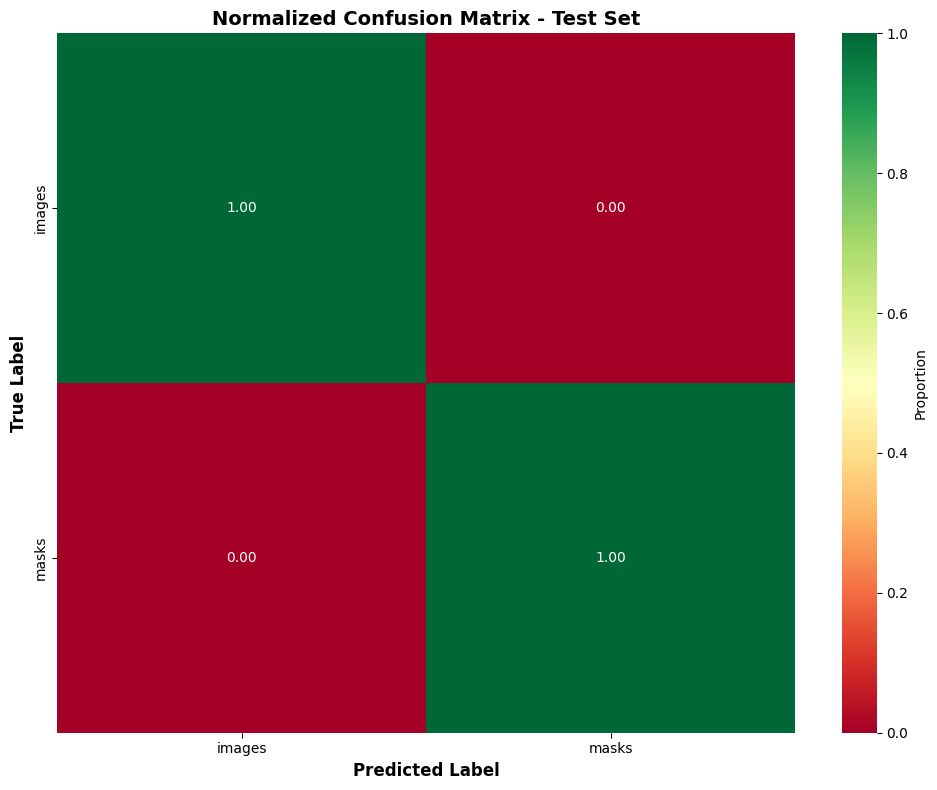

In [15]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
class_names = [idx_to_class[i] for i in range(num_classes)]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='RdYlGn', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Proportion'})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Normalized Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrix_normalized.png'), dpi=150, bbox_inches='tight')
plt.show()

## 10. Prediction Examples
Visualize model predictions on test set

Python(7798) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7799) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7799) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


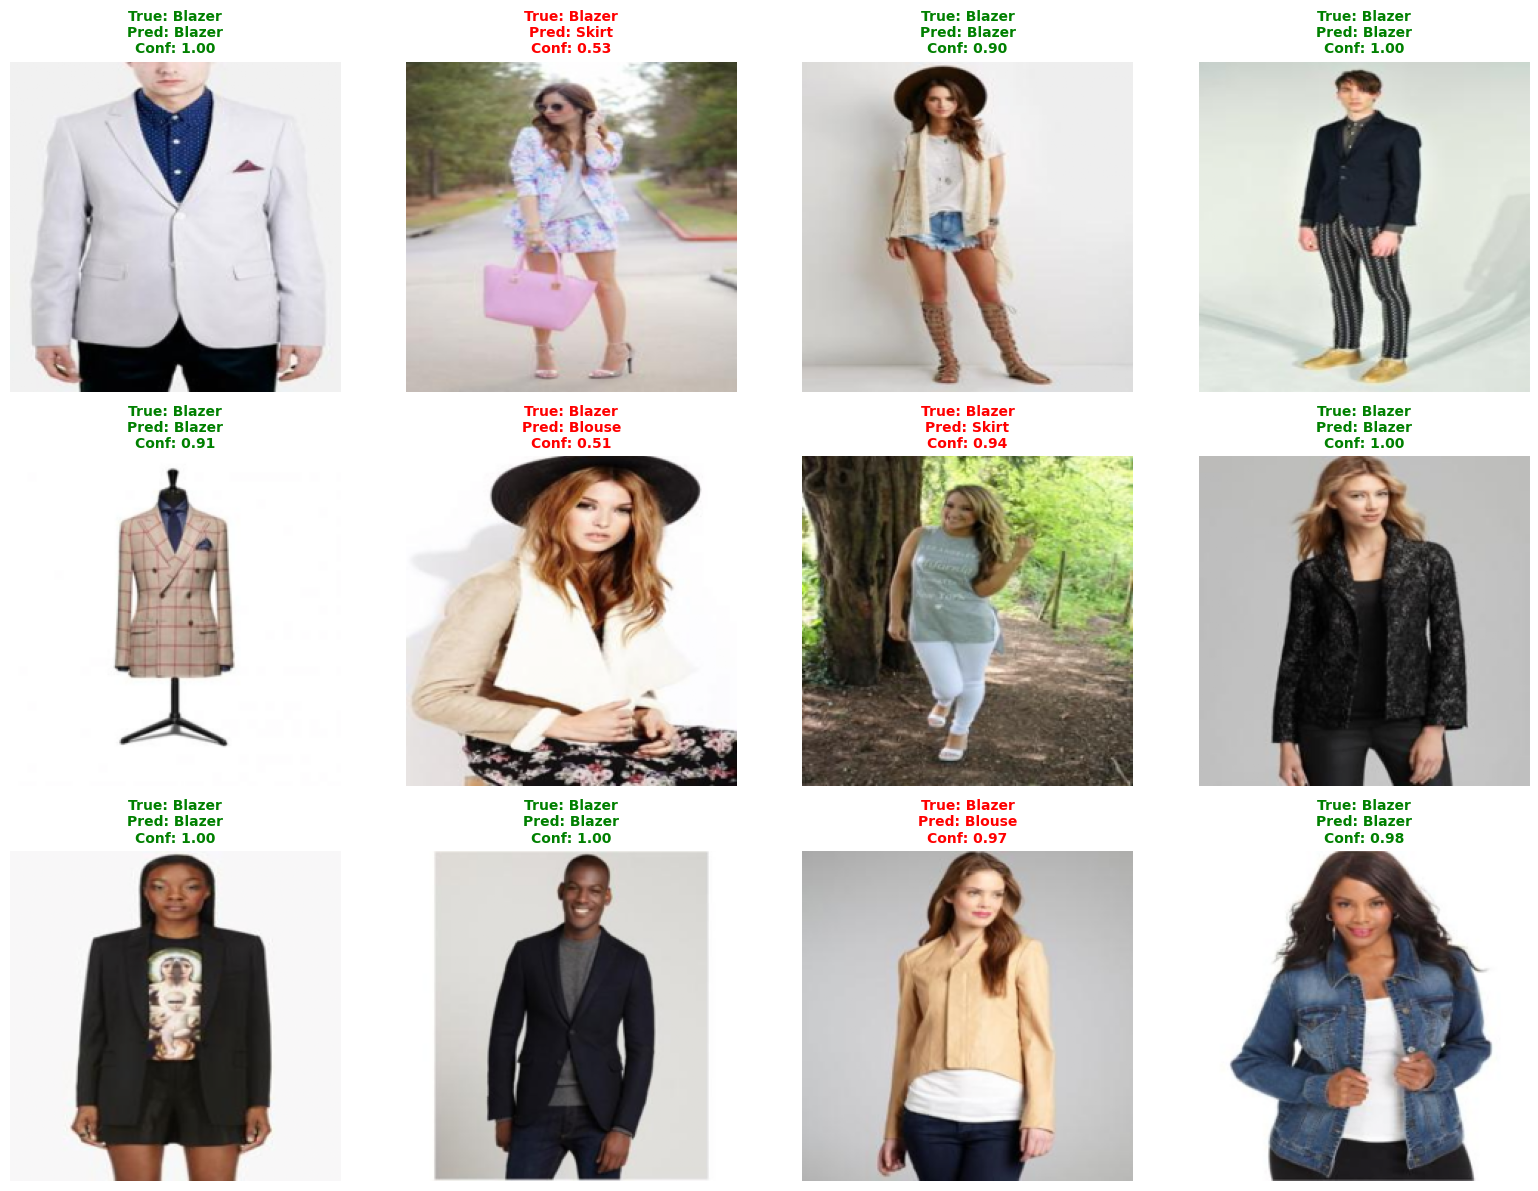

In [31]:
# Show prediction examples
def show_predictions(model, loader, device, idx_to_class, num_images=12):
    model.eval()
    images, labels = next(iter(loader))
    
    with torch.no_grad():
        logits, _ = model(images.to(device))
        probs = torch.softmax(logits, dim=1)
        preds = logits.argmax(1).cpu()
        confidences = probs.max(1)[0].cpu()
    
    # Denormalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images = images * std + mean
    images = torch.clamp(images, 0, 1)
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()
    
    for i in range(min(num_images, len(images))):
        img = images[i].permute(1, 2, 0).numpy()
        true_label = idx_to_class[labels[i].item()]
        pred_label = idx_to_class[preds[i].item()]
        confidence = confidences[i].item()
        
        axes[i].imshow(img)
        
        color = 'green' if preds[i] == labels[i] else 'red'
        title = f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}"
        axes[i].set_title(title, fontsize=10, color=color, fontweight='bold')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'prediction_examples.png'), dpi=150, bbox_inches='tight')
    plt.show()

show_predictions(model, test_loader, device, idx_to_class, num_images=12)

## 11. Feature Embedding Validation
Verification of feature vector extraction capability for downstream recommendation tasks

In [32]:
# Test feature extraction
def extract_features(model, image_path, device):
    model.eval()
    
    # Load and preprocess image
    tfm = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img = Image.open(image_path).convert('RGB')
    x = tfm(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        logits, features = model(x)
        pred_class = logits.argmax(1).item()
        confidence = torch.softmax(logits, dim=1).max().item()
    
    return features.cpu().numpy(), pred_class, confidence

# Test on a sample image
sample_image = list(Path(DATA_ROOT).glob('test/*/*.jpg'))[0]
features, pred_class, confidence = extract_features(model, sample_image, device)

print(f"\nFeature Extraction Test:")
print(f"  Sample image: {sample_image.name}")
print(f"  Feature vector shape: {features.shape}")
print(f"  Predicted class: {idx_to_class[pred_class]}")
print(f"  Confidence: {confidence:.4f}")
print(f"\nFeature extraction validated successfully. System ready for similarity-based recommendation.")


Feature Extraction Test:
  Sample image: img_00000002.jpg
  Feature vector shape: (1, 2048)
  Predicted class: Blouse
  Confidence: 0.9648

Feature extraction validated successfully. System ready for similarity-based recommendation.


## 12. Conclusion and Future Work

### Experimental Results Summary
- **Architecture:** ResNet50 with transfer learning
- **Dataset:** DeepFashion Subset (821 images, 5 categories)
- **Performance Metrics:** Reported in test_metrics.json
- **Training Strategy:** Fine-tuning with frozen backbone layers

### Generated Artifacts
- `results/model_best.pth` - Optimized model weights
- `results/class_to_idx.json` - Class label mapping
- `results/test_metrics.json` - Comprehensive evaluation metrics
- `results/*.png` - Performance visualization plots

### Future Research Directions

#### Immediate Next Steps
1. Gallery indexing: Build feature database from Polyvore outfit dataset
2. Recommendation system: Implement cosine similarity-based outfit matching
3. User interface: Develop interactive demo using Gradio or Streamlit
4. Validation: Evaluate recommendation quality with user studies

#### Performance Optimization Strategies
- **Dataset scaling:** Utilize complete DeepFashion dataset (13,752 images)
- **Training optimization:** Extended epoch training with early stopping
- **Architecture exploration:** Comparative study with EfficientNet, Vision Transformers (ViT)
- **Data augmentation:** Advanced techniques including CutMix, MixUp, AutoAugment
- **Hyperparameter tuning:** Systematic grid search or Bayesian optimization

In [33]:
# Experimental Results Summary
print("\n" + "="*70)
print("TRAINING PIPELINE COMPLETED SUCCESSFULLY")
print("="*70)
print(f"\nPerformance Metrics:")
print(f"  Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"  Test Set Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"\nGenerated Artifacts ({RESULTS_DIR}/):")
print(f"  - model_best.pth: Optimized neural network weights")
print(f"  - class_to_idx.json: Category label mappings")
print(f"  - test_metrics.json: Comprehensive evaluation statistics")
print(f"  - *.png: Training and evaluation visualizations")
print(f"\nSystem Status: Ready for recommendation module implementation")
print("="*70)


TRAINING PIPELINE COMPLETED SUCCESSFULLY

Performance Metrics:
  Best Validation Accuracy: 0.6800 (68.00%)
  Test Set Accuracy: 0.6533 (65.33%)

Generated Artifacts (../results/):
  - model_best.pth: Optimized neural network weights
  - class_to_idx.json: Category label mappings
  - test_metrics.json: Comprehensive evaluation statistics
  - *.png: Training and evaluation visualizations

System Status: Ready for recommendation module implementation
